# Prédiction du temps de transcodage des vidéos

0. [Introduction au transcodage](#Introduction-au-transcodage)
1. [Initialisation](#Initialisation)
2. [Data-visualisation](#Data-visualisation)
3. [Modélisation](#Modélisation)

On utilise deux datasets provenant du *Machine Learning Repository* de l'UCI, regroupés sour la référence [Online Video Characteristics and Transcoding Time Dataset Data Set](https://archive.ics.uci.edu/ml/datasets/Online+Video+Characteristics+and+Transcoding+Time+Dataset). Ces datasets sont les suivants :
* Le premier dataset : `youtube_videos.tsv`, contenant 10 colonnes de caractéristiques diverses de vidéos YouTube ;
* Le second dataset : `transcoding_mesurment.tsv`, contenant 20 colonnes de données relatives au transcodage de vidéos issues du premier dataset, mené sur une machine Intel i7-3720QM CPU grâce au logiciel FFmpeg 4.

Comme nous allons le voir, l'intérêt de tels datasets est de prédire la durée de transcodage de ces vidéos afin d'améliorer le confort de visionnage des utilisateurs. Nous allons pour cela opérer diverses régressions sur les jeux de données afin de déterminer du mieux possible la durée de transcodage et la mémoire allouée à ce transcodage.

----

## Introduction au transcodage

1. Intérêt du transcodage et de l'étude
2. Fonctionnement du transcodage

### Intérêt du transcodage et de l'étude

En vidéo, le transcodage est le fait de changer le format de codage d'un média pour le comprimer ou l'encapsuler dans un fichier, ou pour transporter un signal analogique ou numérique. Bien souvent, la transformation comporte des pertes d'information.

Pour illustrer la nécessité du transcodage des vidéos au quotidien, prenons l'exemple des DVD du commerce du début des années 2010. Au format PAL (25 images par seconde), un film de DVD a une résolution de 720 par 576 pixels. Pour un codage RGB sur 3 octets, cela équivaut à 720 x 557 = 414 720 pixels par image, soit 414 720 x 3 octets pour coder la couleur et la luminance de chaque point. Une image de film fait donc 1 244 160 octets, soit 1 215 ko. À raison de 25 images par seconde, on atteint 30 375 ko, soit 29 Mo par seconde, 1 780 Mo par minute et 104 Go par heure !

Les DVD commerciaux ne pouvant contenir que 4,7 ou 9 Go d'informations, il est nécessaire de compresser l'information et de donc de réaliser un transcodage, d'une source lourde à un fichier de sortie réduit.

A une époque où les résolutions d'images sur des sites web d'hébergement de vidéos augmentent considérablement (on trouve des vidéos de 3 840 x 2 160 pixels sur YouTube aujourd'hui) et où la demande et l'exigeance des consommateurs augmente sur ces plateformes de straming, il parait pertinent de savoir exploiter les données liées à l'encodage de vidéos pour estimer la durée totale de transcodage de ces dernières ou l'espace mémoire total utile au traitement de ces vidéos.

### Fonctionnement du transcodage

Pour "lire" et "écrire" un fichier de vidéo, on utilise un dispositif appelé codec, de l'anglais *coder-decoder*. Différent du *container*, que l'on appelle plus simplement le format de la vidéo (mp4, mov, avi...) et qui regroupe l'ensemble des données image, audio, textuelles et méta, le codec est une implémentation logicielle d'une norme de compression, pour les vidéos dans notre cas. Les codecs les plus répandus aujourd'hui pour la vidéo sont :
* le H.264, datant de 2003, que l'on retrouve dans les fichiers mp4, est le plus utilisé et supporté des codecs ;
* le H.265, sorti en 2013, successeur du H.264. Il a une réduction de bitrate améliorée, mais nécessite plus de ressources et reste peu utilisé ;
* le VP9, développé en 2012 par Google pour YouTube, moins supporté et gourmand en ressources, mais intéressant pour des vidéos en straming et à haute résolution.

Pour compresser un fichier, on peut utiliser des algorithmes de compression sans perte, dits *lossless*, qui nous donnent la garantie qu'aucune information ne disparait lors d'une compression. La compression au format zip en est un. Pour réduire encore plus la taille d'un fichier, il faut accepter de perdre définitivement quelques informations jugées moins utiles. C'est le cas pour les vidéos. Ainsi, la plupart des opérations de transcodage réduisent la quantité d'informations que l'on aura à l'écran lorsque la vidéo sera lue. De plus, pour traiter la décompression et "décoder" les informations relatives à la compression, la machine a besoin de mémoire vive. Plus les opérations de compression seront complexes, plus l'ordinateur devra calculer. Il faut donc trouver le juste équilibre entre la taille du fichier, la qualité de la vidéo et la mémoire vive allouée à la lecture de la vidéo.

On détaille maintenant quelques techniques utilisées par les codecs pour compresser une vidéo.

#### Sous échantillonnage de la chrominance

La première des techniques est évidemment la réduction, certes relative, de la résolution d'une image. Si les dimensions en hauteur et en largeur de la vidéo ne changent pas, le transcodeur peut procéder à une réduction du nombre de pixels "utiles". Un pixel étant défini à la fois par sa luminance Y, sa chrominance bleue Cb et sa chrominance rouge Cr, on peut échantillonner l'image pour définir localement les propriétés des pixels selon l'échantillon auxquels ils appartiennent. Pour conserver une bonne qualité d'image, on pourra par exemple décider que dans un échantillon, si tous les pixels prennent les mêmes chrominances Cb et Cr, ils conservent chacun leur luminance Y individuelle.

![CC BY-SA 4.0 - Ellande - Wikipédia](https://upload.wikimedia.org/wikipedia/commons/1/13/Sous-%C3%A9chantillonnage_de_la_chrominance.png)

Les structures d'échantillonnage sont définies par leurs chiffres J:a:b :
* J est le nombre d'échantillons de luminance (Y) par ligne (toujours identique sur les deux lignes de J pixels). Habituellement, 4 ;
* a est le nombre d'échantillons de chrominance (Cb, Cr) sur la première ligne de pixels ;
* b : le nombre d'échantillons de chrominance (Cb, Cr) sur la deuxième ligne de pixels.

#### Compression spatiale

Une seconde technique consiste à identifier dans une image de vidéo les régions où la couleur est similaire à un seuil déterminée au préalable. Plus une image de vidéo contient de pixels adjacents similaires, plus cette dernière pourra être compressée et son information simplifiée.

Selon le seuil choisi, on pourra remarquer sur la vidéo la présence de rectangles dans lesquels la couleur est identique. Plus la compression est forte, plus les détails d'une image disparaissent.

#### Compression temporelle

La dernière technique de compression de vidéo est la compression temporelle. Il s'agit de la plus importante des techniques dans le cadre de notre étude, car, comme nous allons le voir, de nombreuses données de nos datasets portent sur cette méthode et son fonctionnement. Ici, on ne compresse plus la vidéo image par image mais également sur des périodes temporelles. Des images qui se suivent sur une vidéo comprennent souvent les mêmes objets ou les mêmes paysages. Pour gagner de la place mémoire, on peut considérer que seule l'information de la première image à laquelle apparaît un objet ou un paysage est conservée. Dans le fichier compressé, aucune des images suivantes ne contiendra l'information de l'objet identifié. Elles ne conserveront que la référence expliquant que l'information est à récupérer à l'image précédente. Il est possible de faire de même dans "l'autre sens", en allant chercher une information à l'image suivante. 

Cette technique est d'autant plus intéressante qu'elle est également applicable à des objets en mouvement sur un fond immobile. L'information conservée sur ces images n'est alors que le mouvement de translation de la voiture, les autres informations relatives au fond et à la forme de la voiture étant contenues dans les images précédentes.

Là aussi, la question de similarité des objets ou des paysages entre plusieurs *frames* est sujette à un "seuil de ressemblance". Plus le seuil sera élevé, plus on perdra de petites informations qui pourraient différencier les parties similaires des différentes images et donc moins bonne sera la qualité de la vidéo. De même, aller chercher une information visuelle à une *frame* suivante ou précédente nécessite plus de ressources.

![[Public domain]](https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/I_P_and_B_frames.svg/1920px-I_P_and_B_frames.svg.png)

On identifie alors plusieurs types d'images (*frames*) :
* les *i frames* (*intra-coded picture*), des images complètes contenant toutes l'information dont elles ont besoin ;
* les *p frames* (*predicted picture*), des images ne conservant que les changements par rapport à la précédente image ;
* les *b frames* (*bidirectionnal predicted picture*), des images ne conservant que les changements par rapport à l'image précédente et à l'image suivante. Le traitement de ces images est plus gourmand en ressources.

Les images p et b sont également appelées *inter frames*. Selon le codec, les références aux images précédentes et suivantes peuvent ne concerner qu'une image adjacente ou une image plus éloignée (dans le cas ou l'objet reste immobile plusieurs images d'affilées). Dans le premier cas, le transcodeur doit donc aller, image après image, jusqu'à l'information, ce qui est potentiellement plus gourmand en ressources.

Le codec MPEG-1 utilise également des *d frames*, mais leur intérêt limité a poussé les développeurs à ne pas les intégrer à des codecs plus récents.

----

## Initialisation

1. Bibliothèques et paramètres
2. Récupération des données
3. Traitement des données
4. Répartitions des données

Une fois les datasets téléchargés (à défaut, se référer au REAMDE.md), on peut initialiser le Notebook.

### Bibliothèques et paramètres

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [15]:
palette_codec = { "h264": "C0", "flv1": "C1", "flv": "C1", "mpeg4": "C2", "vp8": "C3", "none": "k"}

### Récupération des données

#### Dataset `youtube_videos.tsv`

On récupère d'abord les données de `youtube_videos.tsv` que l'on met sous forme de DataFrame.

In [3]:
df_youtube_videos = pd.read_csv("input/youtube_videos.tsv",sep="\t")
df_youtube_videos.head()

,id,duration,bitrate,bitrate(video),height,width,frame rate,frame rate(est.),codec,category,url
0,uDNj-_5ty48,267,373,274,568,320,29.97,0.00,h264,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
1,uDNj-_5ty48,267,512,396,480,270,29.97,29.97,h264,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
2,uDNj-_5ty48,267,324,263,400,226,29.97,29.97,flv1,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
3,uDNj-_5ty48,267,85,55,176,144,12.00,12.00,mpeg4,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
4,WCgt-AactyY,31,1261,1183,640,480,24.00,0.00,h264,People & Blogs,http://r1---sn-ovgq0oxu-5goe.c.youtube.com/vid...


Détaillons les propriétés des paramètres numériques de ce dataset de **168 286** éléments.

In [4]:
df_youtube_videos.describe()

,duration,bitrate,bitrate(video),height,width,frame rate,frame rate(est.)
count,168286.000000,168286.00000,168286.000000,168286.000000,168286.000000,168286.000000,168286.000000
mean,271.654184,730.62149,624.363025,561.018706,368.399701,24.564592,19.884441
std,552.881871,919.15473,860.955654,359.071569,201.274180,7.396615,11.435070
min,1.000000,0.00000,0.000000,100.000000,88.000000,0.000000,0.000000
25%,55.000000,289.00000,231.000000,320.000000,240.000000,23.980000,12.000000
50%,145.000000,459.00000,349.000000,480.000000,360.000000,29.920000,25.000000
75%,289.000000,826.00000,640.000000,640.000000,480.000000,29.970000,29.970000
max,25845.000000,22421.00000,22229.000000,2592.000000,1944.000000,59.940000,30.020000


#### Dataset `transcoding_mesurment.tsv`

On fait de même pour les données de `transcoding_mesurment.tsv`.

In [5]:
df_transcoding_mesurment = pd.read_csv("input/transcoding_mesurment.tsv",sep="\t")
df_transcoding_mesurment.head()

,id,duration,codec,width,height,bitrate,framerate,i,p,b,...,p_size,b_size,size,o_codec,o_bitrate,o_framerate,o_width,o_height,umem,utime
0,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,176,144,22508,0.612
1,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,320,240,25164,0.980
2,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,480,360,29228,1.216
3,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,640,480,34316,1.692
4,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,1280,720,58528,3.456


Les propriétés numériques de ce dataset de **68 784** éléments sont :

In [6]:
df_transcoding_mesurment.describe()

,duration,width,height,bitrate,framerate,i,p,b,frames,i_size,p_size,b_size,size,o_bitrate,o_framerate,o_width,o_height,umem,utime
count,68784.000000,68784.000000,68784.000000,6.878400e+04,68784.000000,68784.000000,68784.000000,68784.000000,68784.000000,6.878400e+04,6.878400e+04,68784.0,6.878400e+04,6.878400e+04,68784.000000,68784.000000,68784.000000,68784.000000,68784.000000
mean,286.413921,624.934171,412.572226,6.937015e+05,23.241321,100.868312,6531.692210,9.147854,6641.708377,2.838987e+06,2.218057e+07,0.0,2.502294e+07,1.395036e+06,21.190862,802.336357,503.825541,228224.717900,9.996355
std,287.257650,463.169069,240.615472,1.095628e+06,7.224848,84.764791,6075.871744,92.516177,6153.342453,4.325137e+06,5.097306e+07,0.0,5.414402e+07,1.749352e+06,6.668703,609.959797,315.970438,97430.878373,16.107429
min,31.080000,176.000000,144.000000,8.384000e+03,5.705752,7.000000,175.000000,0.000000,192.000000,1.164800e+04,3.384500e+04,0.0,1.918790e+05,5.600000e+04,12.000000,176.000000,144.000000,22508.000000,0.184000
25%,106.765000,320.000000,240.000000,1.343340e+05,15.000000,39.000000,2374.000000,0.000000,2417.000000,3.933950e+05,1.851539e+06,0.0,2.258222e+06,1.090000e+05,15.000000,320.000000,240.000000,216820.000000,2.096000
50%,239.141660,480.000000,360.000000,2.911500e+05,25.021740,80.000000,5515.000000,0.000000,5628.000000,9.458650e+05,6.166260e+06,0.0,7.881069e+06,5.390000e+05,24.000000,480.000000,360.000000,219480.000000,4.408000
75%,379.320000,640.000000,480.000000,6.529670e+05,29.000000,138.000000,9155.000000,0.000000,9232.000000,3.392479e+06,1.515506e+07,0.0,1.977335e+07,3.000000e+06,25.000000,1280.000000,720.000000,219656.000000,10.433000
max,25844.086000,1920.000000,1080.000000,7.628466e+06,48.000000,5170.000000,304959.000000,9407.000000,310129.000000,9.082855e+07,7.689970e+08,0.0,8.067111e+08,5.000000e+06,29.970000,1920.000000,1080.000000,711824.000000,224.574000


### Traitement des données

Il convient maintenant d'identifier et de supprimer des deux datasets les lignes contenant des valeurs indéterminées.

In [7]:
df_youtube_videos.isna().sum()

id                  0
duration            0
bitrate             0
bitrate(video)      0
height              0
width               0
frame rate          0
frame rate(est.)    0
codec               0
category            0
url                 0
dtype: int64

In [8]:
df_transcoding_mesurment.isna().sum()

id             0
duration       0
codec          0
width          0
height         0
bitrate        0
framerate      0
i              0
p              0
b              0
frames         0
i_size         0
p_size         0
b_size         0
size           0
o_codec        0
o_bitrate      0
o_framerate    0
o_width        0
o_height       0
umem           0
utime          0
dtype: int64

Nos jeux de données sont donc déjà nettoyés car aucune colonne des deux datasets ne contiennent des valeurs indéterminées.

### Répartitions des données

On s'assure maintenant que les datasets sont diversifiés et que les données non numériques sont équitablement réparties.

#### Paramètres `codec`

[Text(0.5, 1.0, 'o_codec - transcoding_mesurments')]

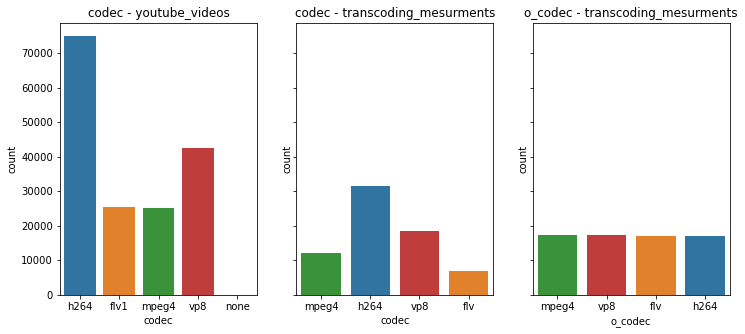

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
sns.countplot(x="codec", data=df_youtube_videos, ax=axes[0], palette=palette_codec).set(title="codec - youtube_videos")
sns.countplot(x="codec", data=df_transcoding_mesurment, ax=axes[1], palette=palette_codec).set(title="codec - transcoding_mesurments")
sns.countplot(x="o_codec", data=df_transcoding_mesurment, ax=axes[2], palette=palette_codec).set(title="o_codec - transcoding_mesurments")

#### Paramètre `category`

[Text(0.5, 1.0, 'Répartition des vidéos YouTube par catégorie')]

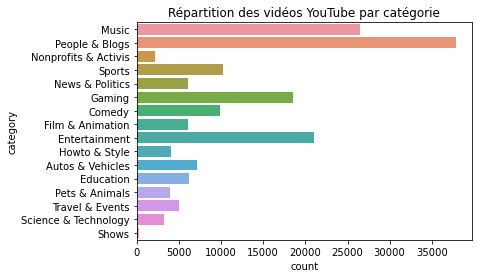

In [25]:
sns.countplot(y="category", data=df_youtube_videos).set(title="Répartition des vidéos YouTube par catégorie")

La répartition des vidéos par codecs n'est pas équilibrée dans les deux datasets. Il n'y a pas non plus de proportion de répartition similaire entre les deux datasets.

Il faut maintenant intégrer les codecs dans ces données et confronter les deux datasets.

----

## Data-visualisation

1. Analyse des rapports entre les paramètres
2. Influence des choix des codecs
3. Influence des données sur les frames de transcoding

Il s'agit, dans cette partie, de montrer le lien entre les variables et la cible.

### Analyse des rapports entre les paramètres

On regarde d'abord quelles sont les corrélations entre les différentes colonnes de nos datasets.

#### Dataset `youtube_videos.tsv`

[Text(0.5, 1.0, 'Table de corrélations de youtube_videos.tsv')]

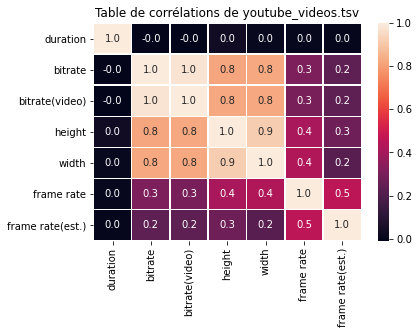

In [15]:
f, axes = plt.subplots()
sns.heatmap(df_youtube_videos.corr(), annot=True, linewidths=.5, fmt= '.1f').set(title="Table de corrélations de youtube_videos.tsv")

Les paramètres `bitrate`, `bitrate_video`, `height` et `weight` sont logiquement fortement corrélés : plus l'image est grande, plus elle est lourde en pixels et donc plus le débit en bits par seconde est élevé.

On constate également la corrélation moyenne entre le débit d'image par secondes `frame rate` et les paramètres de taille de l'image. On peut penser que plus la vidéo a un important débit d'image, plus elle est également de bonne qualité en taille. Toutefois, il n'y a que peu de corrélation entre le débit d'image et le débit de pixels.

On va s'intéresser en particulier aux rapports entre les paramètres suivants :
* `bitrate` et `bitrate(video)`
* `height` et `width`
* `bitrate` et dimensions

##### Rapport entre `bitrate` et `bitrate(video)`

Text(0.2, 0.75, '[  0.91684205 -45.50147931]')

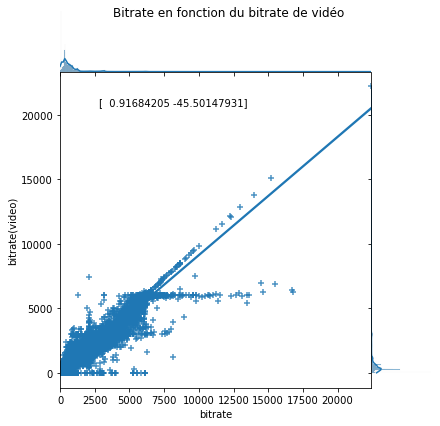

In [41]:
reg = np.polyfit(df_youtube_videos["bitrate"], df_youtube_videos["bitrate(video)"], 1)
p = sns.jointplot(data=df_youtube_videos, x="bitrate", y="bitrate(video)", kind="reg", marker="+", space=0)
p.fig.suptitle("Bitrate en fonction du bitrate de vidéo")
p.fig.text(0.2, 0.75, str(reg))                                

Globalement, le bitrate de vidéo est équivalent au bitrate.

On pourrait maintenant se demander si le codec influe sur le rapport entre `bitrate(video)` et `bitrate`.

(0.0, 200.0)

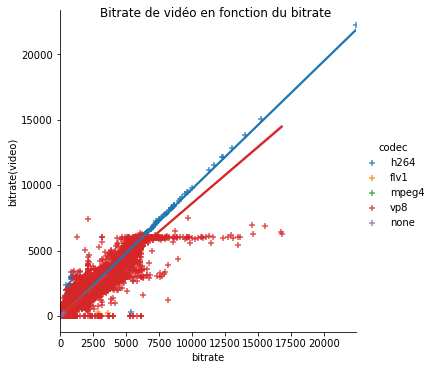

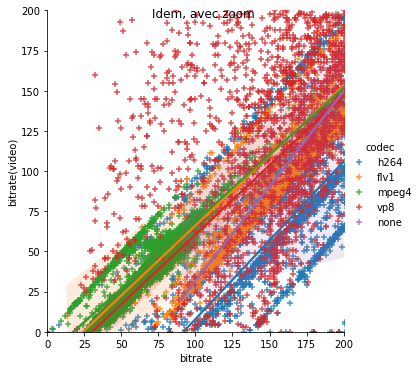

In [47]:
p = sns.lmplot(data=df_youtube_videos, x="bitrate", y="bitrate(video)", hue="codec", markers="+")
p.fig.suptitle("Bitrate de vidéo en fonction du bitrate")

p = sns.lmplot(data=df_youtube_videos, x="bitrate", y="bitrate(video)", hue="codec", markers="+")
p.fig.suptitle("Idem, avec zoom")
plt.xlim(0, 200)
plt.ylim(0, 200)

La corrélation entre le bitrate de vidéo et le bitrate est très importante pour les codecs h264, flv1 et mpeg4. 

Pour les codecs vp8, ce même rapport fluctue beaucoup plus. On note même un seuil à 6 000 bit/s au-delà duquel le débit de bits de vidéo `bitrate(video)` n'augmente plus, contrairement au `bitrate` qui peut dépasser 15 000 bit/s.

##### Rapport entre `height` et `width`

Les rapports entre hauteur et largeur de la vidéo sont évidemment très normalisés. On le constate encore ici.

Text(0.5, 0.98, "Largeur de l'image en fonction de la hauteur")

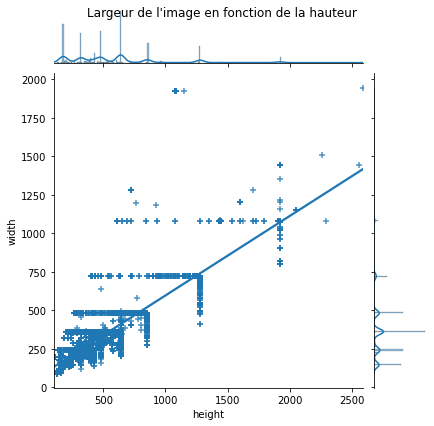

In [48]:
p = sns.jointplot(data=df_youtube_videos, x="height", y="width", kind="reg", marker="+")
p.fig.suptitle("Largeur de l'image en fonction de la hauteur")

##### Rapport entre `bitrate` et dimensions de la vidéo

On constate logiquement que lorsque les dimensions d'une vidéo augmentent, le débit en bit par seconde augmente.

Text(0.2, 0.75, '[   2.10160005 -448.41545048]')

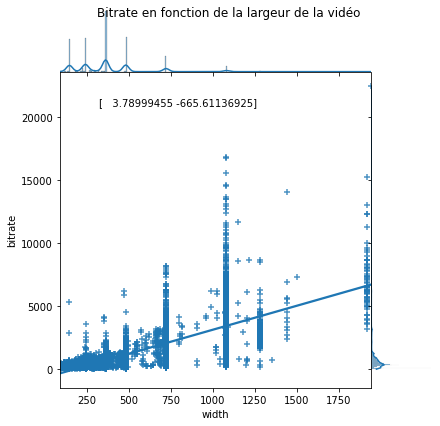

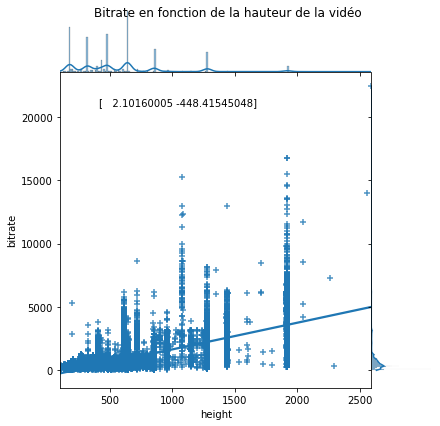

In [60]:
reg = np.polyfit(df_youtube_videos["width"], df_youtube_videos["bitrate"], 1)
p = sns.jointplot(data=df_youtube_videos, x="width", y="bitrate", kind="reg", marker="+", space=0)
p.fig.suptitle("Bitrate en fonction de la largeur de la vidéo")
p.fig.text(0.2, 0.75, str(reg))   

reg = np.polyfit(df_youtube_videos["height"], df_youtube_videos["bitrate"], 1)
p = sns.jointplot(data=df_youtube_videos, x="height", y="bitrate", kind="reg", marker="+", space=0)
p.fig.suptitle("Bitrate en fonction de la hauteur de la vidéo")
p.fig.text(0.2, 0.75, str(reg))   

#### Autres rapports entre les paramètres du dataset

Pour n'écarter aucune auctre relation entre les paramètres de `df_youtube_videos`, on réalise la table des relations complètes du dataset en attribuant une couleur par classe de codec. On remarque alors d'autres particularités intéressantes, comme le fait que les dimensions des vidéos de codec flv1 et mpeg4 sont très limitées : au plus 500 px de `height` pour 300 px de `width`, ou que le `framerate` des vidéos de codec vp8 ne dépasse jamais les 30 images/s.

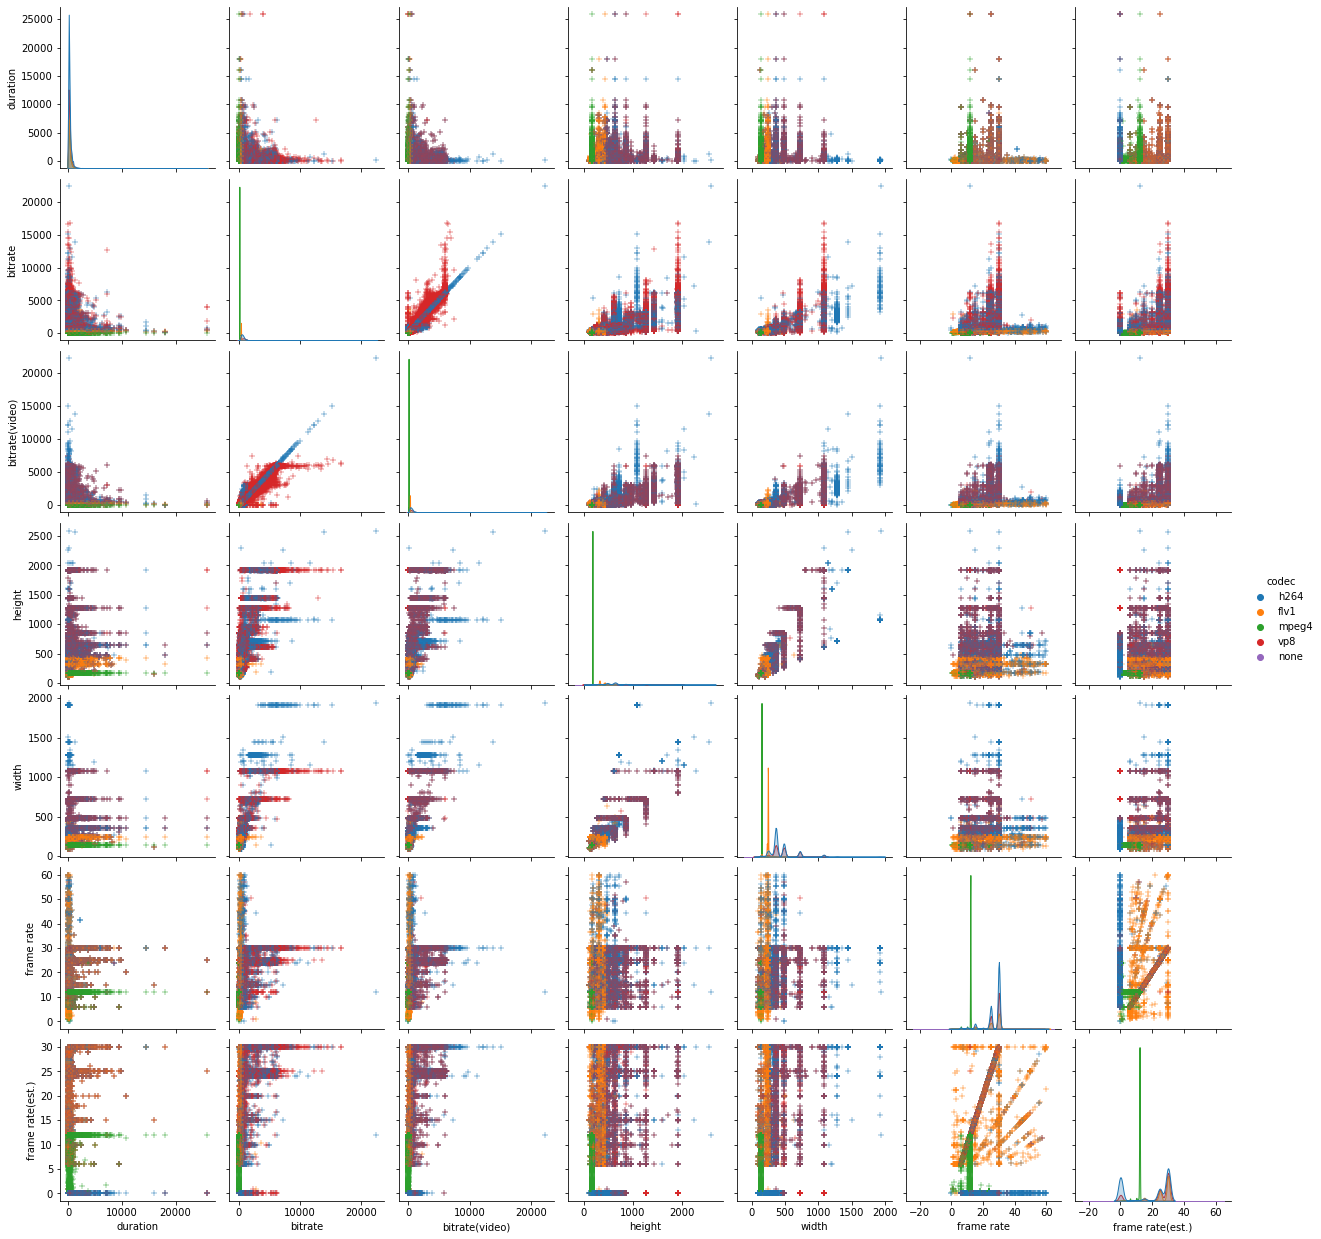

In [58]:
sns.pairplot(df_youtube_videos, hue="codec", markers="+")

#### Dataset `transcoding_mesurment.tsv`

[Text(0.5, 1.0, 'Table de corrélations de transcoding_mesurment.tsv')]

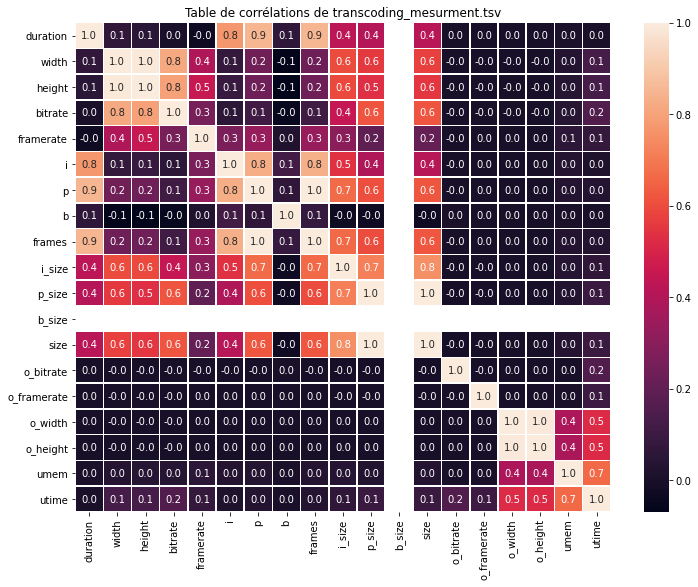

In [27]:
fib, axes = plt.subplots(figsize=(12, 9))
sns.heatmap(df_transcoding_mesurment.corr(), annot=True, linewidths=.5, fmt= '.1f').set(title="Table de corrélations de transcoding_mesurment.tsv")

Les paramètres `width` et `height` sont comme pour le premier dataset très corrélés. Ils sont également moyennement corrélés avec la taille de l'image `size` et avec `o_width` et `o_height`. 

Concernant la durée de transcodage `utime`, elle est moyennement corrélée avec `o_width` et `o_height`, les tailles d'image de sortie du transcodage. Elle est également plutôt corrélée avec la mémoire allouée pour le transcodage `umem`.

On va s'intéresser en particulier, comme pour le premier dataset, aux rapports entre les paramètres suivants :
* `bitrate` et `bitrate(video)`
* `bitrate` et dimensions

##### Rapport entre `bitrate` et `bitrate(video)`

**Durée de transcodage en fonction du débit en bit/s**

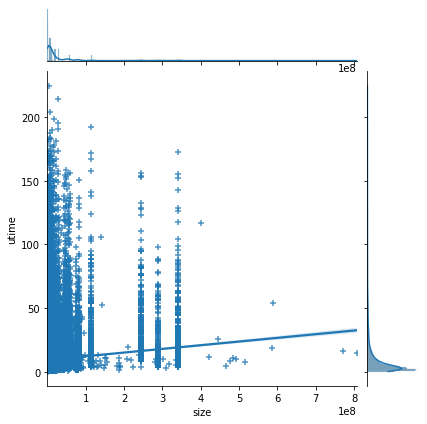

In [69]:
sns.jointplot(data=df_transcoding_mesurment, x="size", y="utime", kind="reg", marker="+")

Les données semblent cohérentes : la largeur `width` et la hauteur `height` de l'image sont corrélés et le débit en bit `bitrate` évolue dans le sens de la taille de l'image, du débit en bit propre à la vidéo `bitrate(video)` ou encore du nombre d'image par secondes `frame rate`, mais pas dans le sens de la durée de la vidéo `duration`, ce qui semble aussi normal, débit en bit et durée étant *a priori* indépendants.

On confirme ces observations avec la table de corrélation des paramètres du dataset.

In [61]:
from sklearn import tree
X = [[0, 0], [2, 2]]
y = [0.5, 2.5]
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X, y)
clf.predict([[1, 1]])

array([0.5])

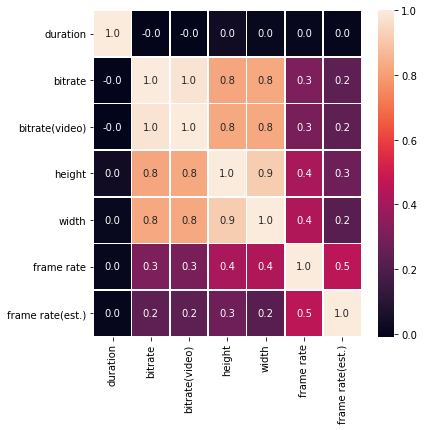

In [57]:
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(df_youtube_videos.corr(), annot=True, linewidths=.5, fmt= '.1f')

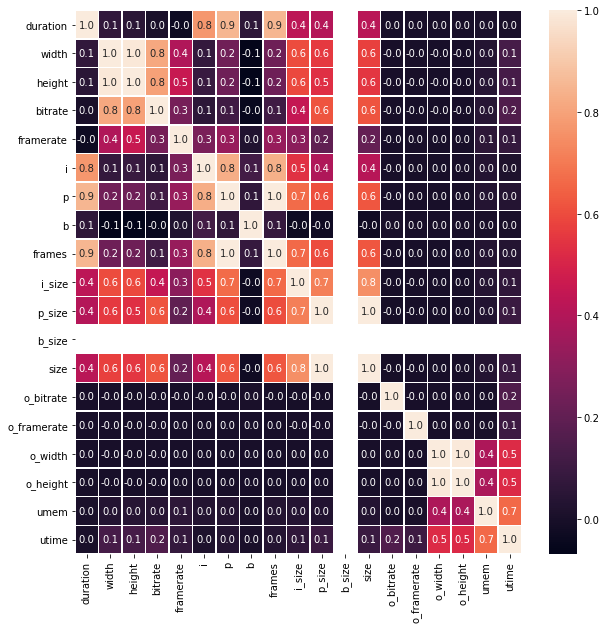

In [55]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_transcoding_mesurment.corr(), annot=True, linewidths=.5, fmt= '.1f')

C:\Users\anato\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\anato\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\anato\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\anato\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


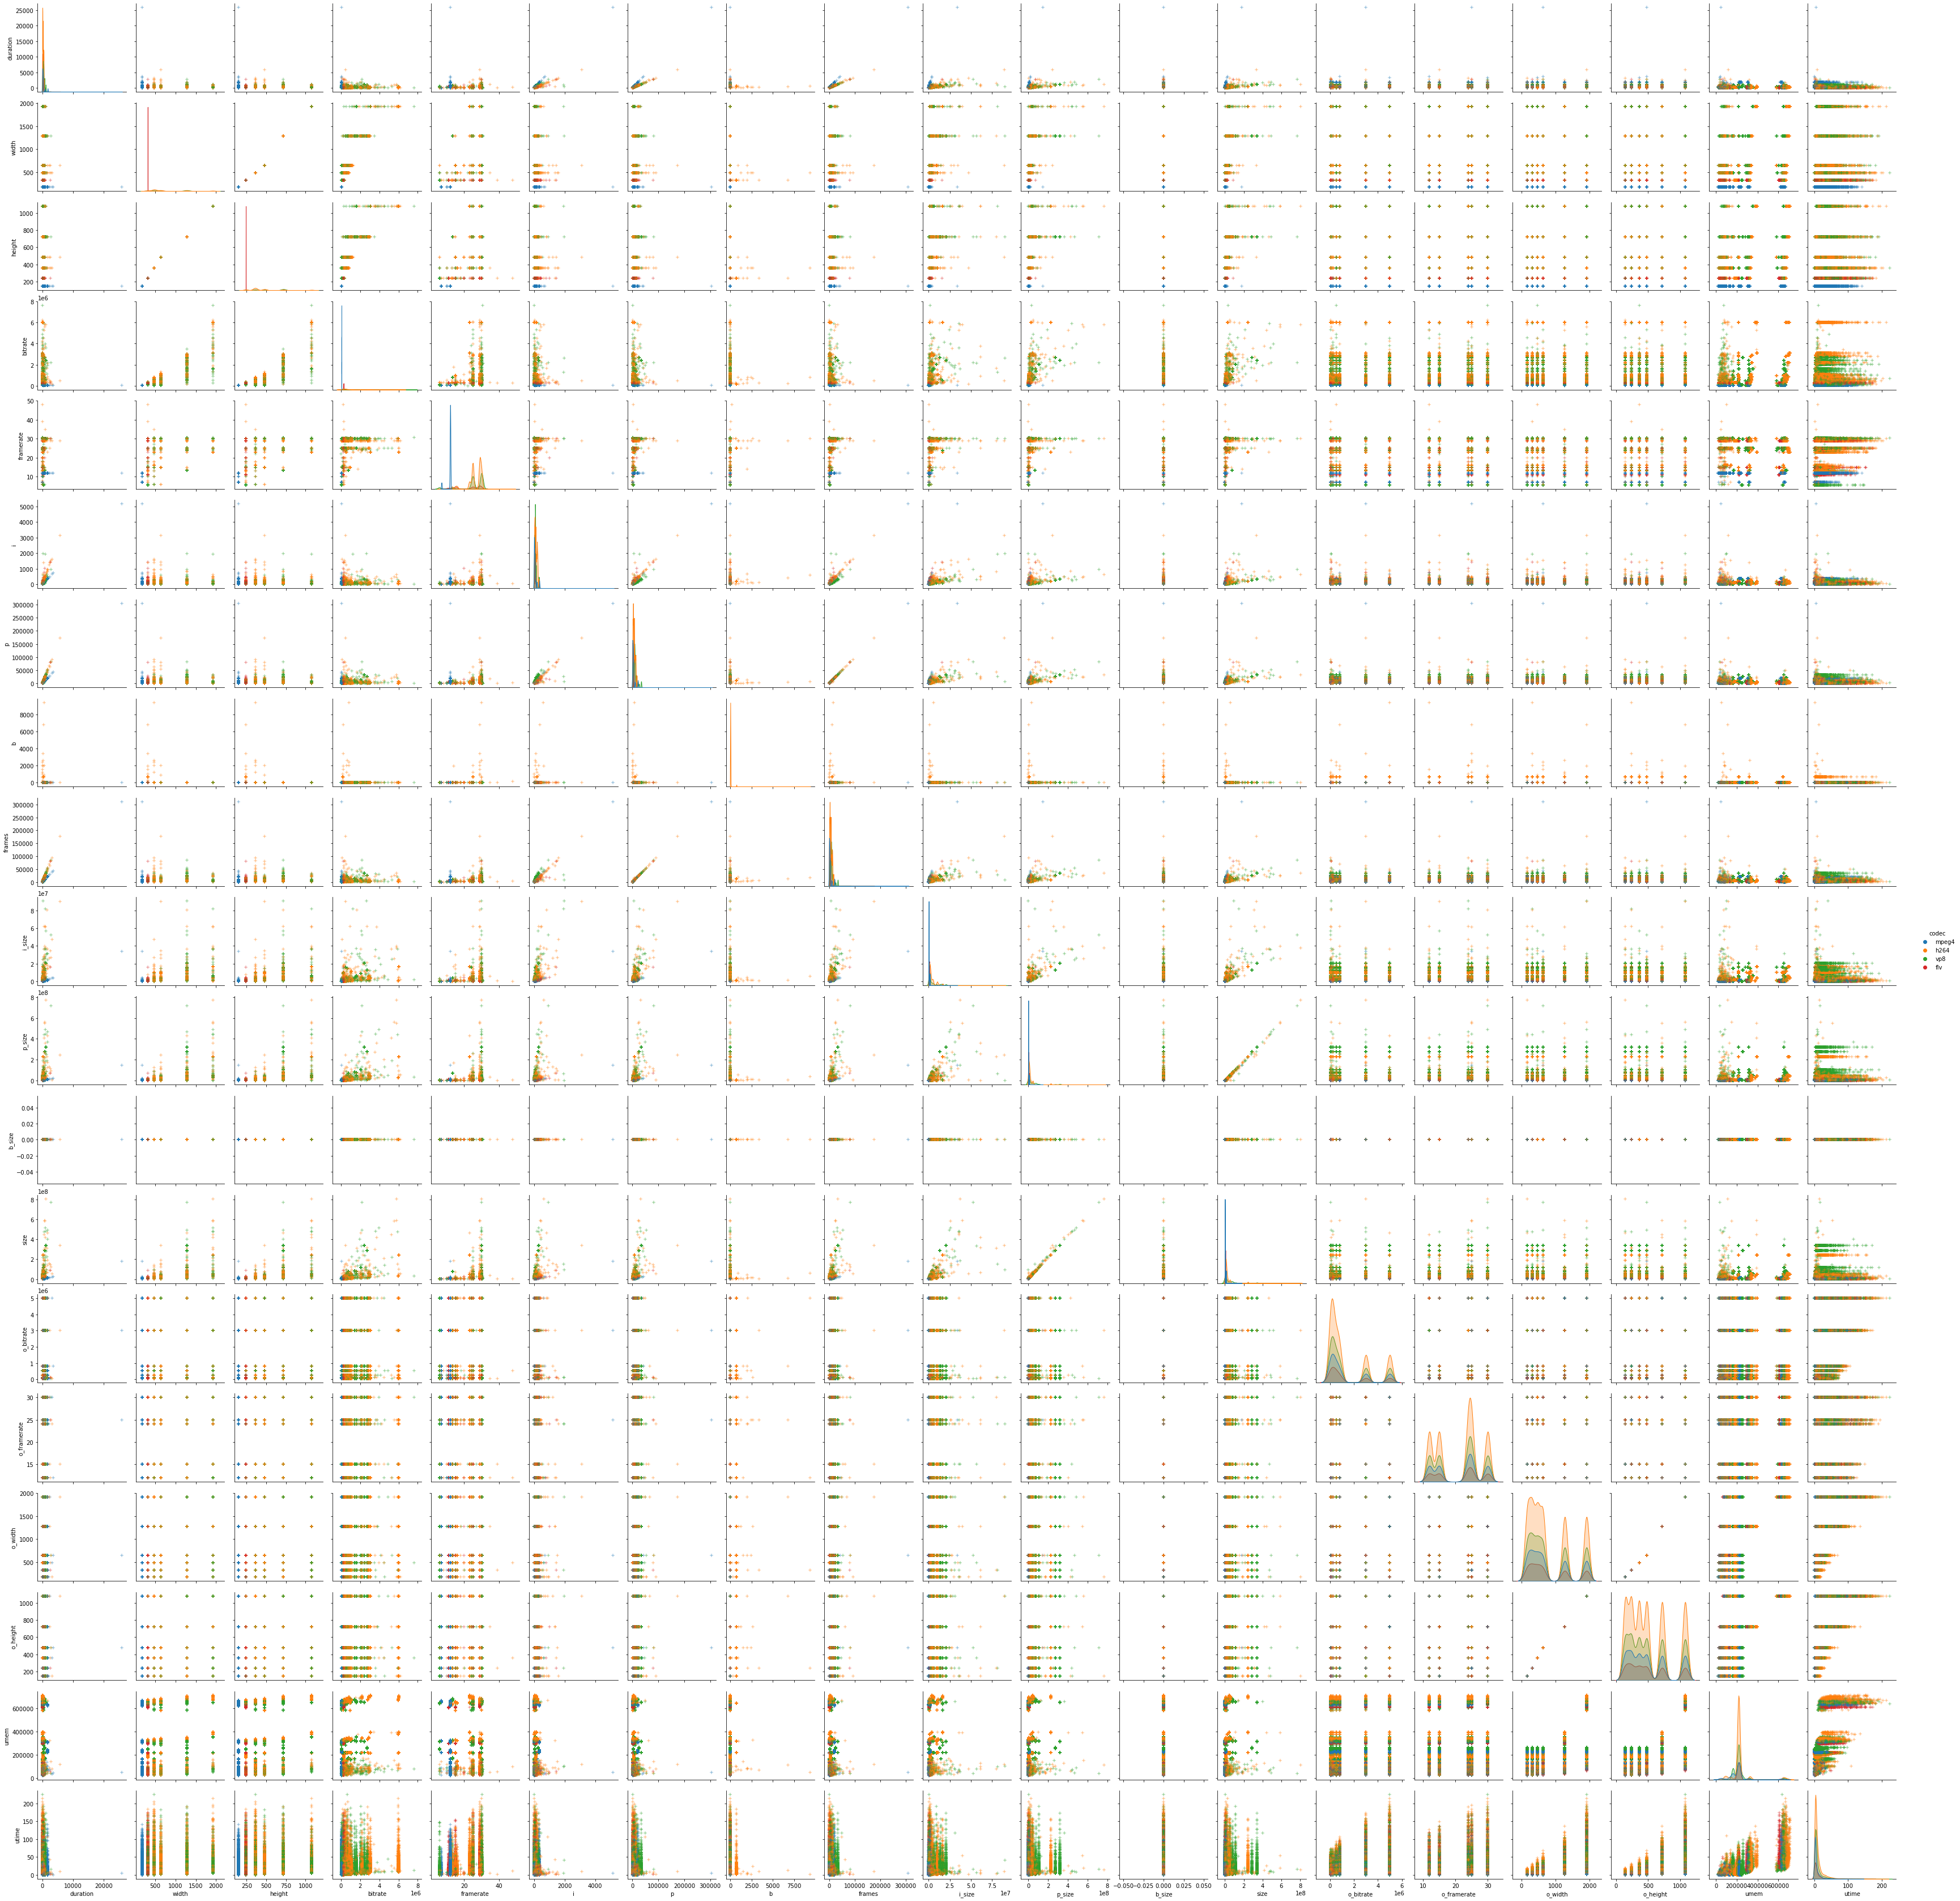

In [59]:
sns.pairplot(df_transcoding_mesurment, hue="codec", markers="+")